# **Predicción de supervivencia en el Titanic**


## Introducción
En este proyecto vamos a construir modelos de clasificación para predecir si un pasajero del Titanic sobrevivió o no, utilizando datos reales. Compararemos dos modelos: Random Forest y Regresión Logística.

### Importamos las bibliotecas que vamos a necesitar


In [1]:
# Importa la biblioteca NumPy para operaciones numéricas y manejo de arrays
import numpy as np

# Importa pandas para manipulación y análisis de datos en estructuras tipo DataFrame
import pandas as pd

# Importa matplotlib para crear gráficos y visualizaciones
import matplotlib.pyplot as plt

# Importa funciones para dividir datos, validación cruzada y búsqueda de hiperparámetros
from sklearn.model_selection import train_test_split

# Importa seaborn para visualizaciones estadísticas más atractivas
import seaborn as sns

# Importa el clasificador Random Forest
from sklearn.ensemble import RandomForestClassifier

# Importa regresión logística como modelo de clasificación
from sklearn.linear_model import LogisticRegression

# Importa métricas para evaluar modelos de clasificación
from sklearn.metrics import classification_report, confusion_matrix

## Paso 1: Carga y exploración del dataset
Exploramos las variables disponibles en el conjunto de datos del Titanic, identificamos las que tienen valores faltantes y decidimos cuáles usar para el modelo.

### Dataset de pasajeros del Titanic
El dataset del Titanic consta de las siguientes variables (columnas)

| Variable   |	Definición   |
 |:------|:--------------------------------|
 |survived | Sobrevivió? 0 = No, 1 = sí  |
 |pclass | Clase del billete: primera, segunda o tercera (int)  |
 |sex	 |Sexo |
 |age	 | Edad  |
 |sibsp  |	Número de hermanos o cónyuges a bordo del Titanic |
 |parch  |	Número de padres o hijos a bordo del Titanic |
 |fare   |	Tarifa del billete |
 |embarked | Código del puerto de embarque. C= Cherbourg, Q = Queenstown, S= Southampton |
 |class  |Clase del billete; First (1ª), Second (2ª), Third (3ª) (objeto - categórica) |
 |who    | Hombre / Mujer / Niño|
 |adult_male | Hombre adulto: Verdadero/Falso|
 |deck | Cubierta asignada|
 |embark_town | Ciudad de embarque|
 |alive  | Vivo. Sí/No|
 |alone  | Viajaba solo. Sí/No|

Vamos a construir un modelo de clasificación que prediga si un pasajero sobrevivió o no al hundimiento del Titanic.

### Cargamos el dataset del Titanic usando Seaborn


In [2]:
# Carga el conjunto de datos del Titanic incluido en seaborn
titanic = sns.load_dataset('titanic')

# Muestra las primeras 5 filas del DataFrame para explorar su estructura
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Paso 2: Selección de variables
Seleccionamos las variables más relevantes para predecir la supervivencia, eliminando las que tienen demasiados valores faltantes o están duplicadas.

### Seleccionamos características relevantes y el objetivo


In [3]:
# Cuenta el número de valores no nulos (no faltantes) en cada columna del DataFrame
titanic.count()

,0
survived,891
pclass,891
sex,891
age,714
sibsp,891
parch,891
fare,891
embarked,889
class,891
who,891


#### Variables que debemos eliminar
* deck tiene muchos valores ausentes, así que la eliminaremos.
* age también tiene bastantes valores faltantes, aunque podría ser relevante. Sin embargo, la haremos variable de intervalo.
* embarked y embark_town no parecen relevantes, así que también las eliminaremos.
* sex, who y adult_male indican información similar. Dejamos solo sex.
* fare, es la tarifa que pagaron, pero en el fondo, está relacionada con la clase, dejamos solo clase.
* Class y pclass indican información similar, dejamos class
* sibsp y parch son el número de hermanos y el número de padres o hijos, que están relacionadas con si viajaba solo o no (alone), dejaremos solo la variable alone.
* alive está repetida, por lo que la ignoraremos.

#### Variable objetivo
survived es nuestra variable objetivo de clasificación.

#### Hacemos age variable de intervalo

In [4]:
# Esta función convierte la edad numérica en una categoría: niño, joven, adulto o mayor
def categorizar_edad(age):
    if age < 12:
        return 'niño'
    elif age < 20:
        return 'joven'
    elif age < 60:
        return 'adulto'
    else:
        return 'mayor'

# Creamos la columna age_group aplicando las categorías
titanic['age_group'] = titanic['age'].apply(categorizar_edad)


In [5]:
# Definimos las variables independientes (características) que usaremos para entrenar el modelo
features = ['sex', 'age_group', 'class', 'alone']

# Definimos la variable objetivo que queremos predecir: si el pasajero sobrevivió o no
target = 'survived'

# Extraemos las columnas seleccionadas del DataFrame como variables independientes (X)
X = titanic[features]

# Extraemos la columna de la variable objetivo como variable dependiente (y)
y = titanic[target]

## Paso 3: Preprocesamiento
En este paso aplicamos transformaciones necesarias para preparar los datos antes de entrenar los modelos. Esto incluye imputación, codificación y escalado.

### ¿Cómo de balanceadas están las clases?


In [6]:
# Cuenta cuántas veces aparece cada clase en la variable objetivo 'survived'
# Es decir, cuántos pasajeros sobrevivieron (1) y cuántos no (0)
y.value_counts()

,count
survived,
0,549
1,342


Aproximadamente el 38 % de los pasajeros del conjunto de datos sobrevivieron.
Debido a este ligero desequilibrio, deberíamos estratificar los datos al realizar la división entre entrenamiento y prueba, así como en la validación cruzada.

Estratificar significa asegurarse de que la proporción de clases (sobrevivientes y no sobrevivientes) se mantenga constante en cada subconjunto de datos. Esto ayuda a que el modelo aprenda de forma equilibrada y no se sesgue hacia la clase mayoritaria.

### Dividiremos los datos en entrenamiento y test.
Tendremos en cuenta el desequilibrio detectado.


In [7]:
# Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Usamos una semilla aleatoria (random_state=42) para que los resultados sean reproducibles
# Aplicamos estratificación para mantener la proporción de clases ('survived') en ambos subconjuntos
# stratify=y estratifica por la variable objetivo para mantener la proporción de clases entre ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Imputación de valores faltantes

Si imputaras los valores faltantes antes de dividir los datos, estarías usando información del conjunto de prueba para modificar el conjunto de entrenamiento. Esto puede hacer que el modelo aprenda patrones que no debería conocer, lo que lleva a:

* Resultados artificialmente buenos en la evaluación.
* Modelos que no generalizan bien a datos nuevos.

In [8]:
# Usamos la moda para variables categóricas porque es el valor más frecuente
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_train.mode().iloc[0])

### Codificación de variables categóricas

In [9]:
# Codificamos las variables categóricas en formato binario (One-Hot Encoding)
# Esto convierte cada categoría en una columna con valores 0 o 1, permitiendo que el modelo las procese
# Esto es necesario porque los modelos de machine learning no pueden trabajar directamente con texto
# Por ejemplo, 'sex' se convierte en 'sex_male' y 'sex_female', 'class' en 'class_Third'...
# drop_first=False para conservar todas las categorías (evita pérdida de información)
X_train_encoded = pd.get_dummies(X_train, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, drop_first=False)


# Alineamos las columnas entre entrenamiento y prueba
# Esto asegura que ambos conjuntos tengan las mismas variables, incluso si alguna categoría no aparece en ambos
# esto evita errores si alguna categoría no aparece en el conjunto de prueba
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


## Paso 4: Entrenamiento del modelo de Random Forest
Usamos Random Forest para entrenar un modelo de clasificación con los datos preprocesados.

In [10]:
# Entrenamos un modelo de Random Forest
# Este modelo combina múltiples árboles de decisión y suele ofrecer buen rendimiento sin necesidad de mucho ajuste

model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

## Paso 5: Evaluación del modelo de Random Forest
Evaluamos el rendimiento del modelo con métricas como precisión, recall y F1-score, y visualizamos la matriz de confusión.

### Obtenemos las predicciones del modelo en los datos no vistos.
Imprimimos un informe de clasificación.


In [11]:
# Se generan las predicciones del modelo.
# Se utiliza el conjunto de datos de prueba (X_test), que no fue usado durante el entrenamiento
y_pred = model.predict(X_test_encoded)

# Se imprime un informe de clasificación que incluye métricas como:
# - Precisión (precision): proporción de verdaderos positivos entre los predichos como positivos
# - Exhaustividad o sensibilidad (recall): proporción de verdaderos positivos entre los casos reales positivos
# - F1-score: media armónica entre precisión y recall
# - Soporte (support): número de ocurrencias reales de cada clase en el conjunto de prueba
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.95      0.85       110
           1       0.86      0.54      0.66        69

    accuracy                           0.79       179
   macro avg       0.81      0.74      0.75       179
weighted avg       0.80      0.79      0.77       179



Este informe permite analizar cómo de bien el modelo distingue entre pasajeros que sobrevivieron y los que no. Las métricas clave como precisión, recall y F1-score ayudan a entender el equilibrio entre aciertos y errores.

### Dibujamos la matriz de confusión


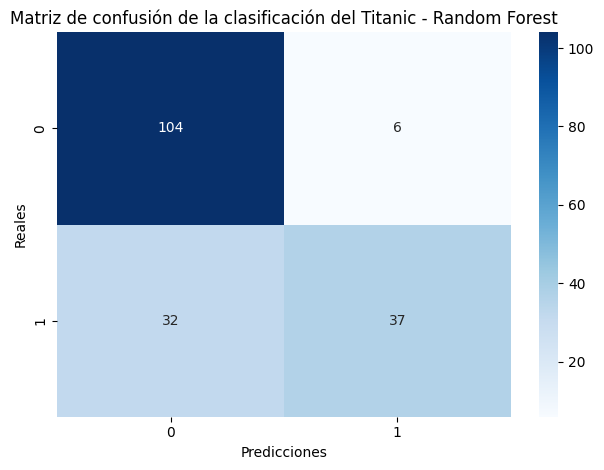

In [12]:

# Genera la matriz de confusión a partir de las etiquetas reales (y_test) y las predichas por el modelo (y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Crea una nueva figura para el gráfico
plt.figure()

# Dibuja la matriz de confusión como un mapa de calor
# - annot=True: muestra los números dentro de cada celda
# - cmap='Blues': usa una paleta de colores azules
# - fmt='d': formato de los números como enteros
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Establece el título del gráfico
plt.title('Matriz de confusión de la clasificación del Titanic - Random Forest')

# Etiqueta del eje X (predicciones del modelo)
plt.xlabel('Predicciones')

# Etiqueta del eje Y (valores reales)
plt.ylabel('Reales')

# Ajusta automáticamente el diseño para que no se sobrepongan los elementos
plt.tight_layout()

# Muestra el gráfico en pantalla
plt.show()


La matriz muestra que el modelo predice mejor la clase 0 (no sobrevivió) que la clase 1 (sí sobrevivió), lo cual es común en datasets desbalanceados. Hay 32 personas que están vivas, pero las clasifica como muertas (Falso negativo) y 6 personas clasificadas como vivas, pero que estaban muertas (Falso positivo).
| Fallecido pred correcta | Fallecido pred incorrecta | Superviviente pred correcta | Superviviente pred incorrecta | TOTAL |
|----------|----------|------------|-------------|---------|
| 104 | 6 | 37 | 32 | 179 |
| 58% | 3% | 21% | 18% | 100% |

Ha clasificado incorrectamente un 21% de los 179 casos reservados para el test (20% de los 891 pasajeros).

### Importancia de variables

In [13]:
# Extraemos la importancia de cada variable según el modelo Random Forest
feature_importances = model.feature_importances_
# Obtenemos los nombres de las variables codificadas
feature_names = X_train_encoded.columns

### Muestra la importancia de las variables en un gráfico de barras
Define un DataFrame con la importancia de las variables y luego represéntalo gráficamente.


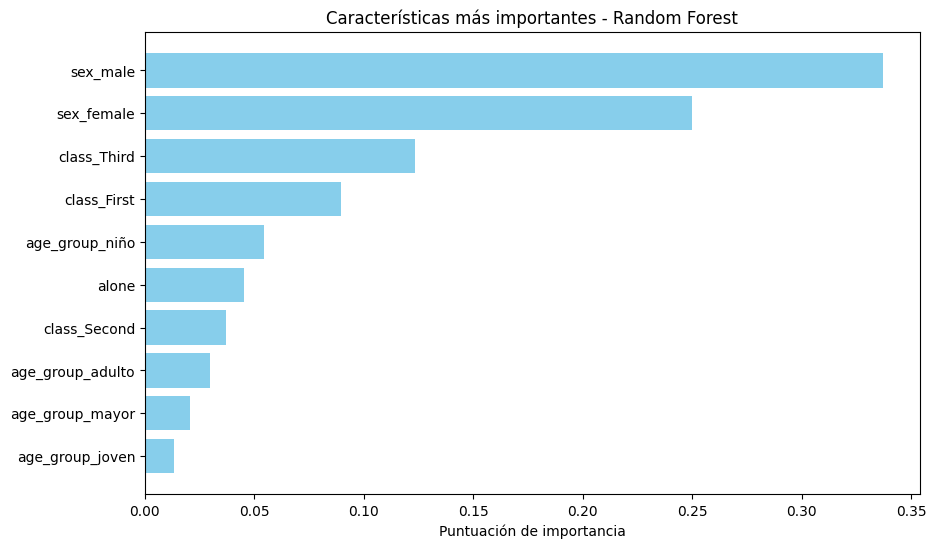


Test set accuracy: 78.77%


In [14]:
# Crear un DataFrame con los nombres de las variables y sus respectivas importancias
# Luego se ordena de mayor a menor según la importancia
importance_df = pd.DataFrame({
    'Feature': feature_names,           # Lista de nombres de las variables (numéricas + categóricas codificadas)
    'Importance': feature_importances   # Importancia de cada variable según el modelo
}).sort_values(by='Importance', ascending=False)

# --- Visualización de las importancias ---

# Crear una figura de tamaño 10x6 pulgadas para el gráfico
plt.figure(figsize=(10, 6))


# Visualizamos qué variables influyen más en la predicción
# Esto ayuda a interpretar el modelo y entender el problema
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')

# Invertir el eje Y para que las variables más importantes aparezcan arriba
plt.gca().invert_yaxis()

# Título del gráfico
plt.title('Características más importantes - Random Forest')

# Etiqueta del eje X
plt.xlabel('Puntuación de importancia')

# Mostrar el gráfico
plt.show()

# --- Evaluación del modelo en el conjunto de prueba ---

# Calcular la precisión del modelo en los datos de prueba
test_score = model.score(X_test_encoded, y_test)

# Imprimir la precisión en formato porcentaje con dos decimales
print(f"\nTest set accuracy: {test_score:.2%}")

Las variables con mayor puntuación en el eje X tienen más influencia en la decisión del modelo. Esto puede ayudar a identificar factores clave.

## Paso 6: Interpretación de resultados

La precisión en el conjunto de prueba es algo satisfactoria.

Por ejemplo, no hay duda de que la variable 'sex' tiene información significativa, parece la más relevante, seguida de 'class' y luego 'age_group', si viajaban solos o no, también tiene relevancia, pero menor.

# Probar otro modelo
En la práctica, querrás probar diferentes modelos e incluso revisitar el análisis de datos para mejorar el rendimiento de tu modelo.
Tal vez puedas crear nuevas variables (ingeniería de características) o imputar valores faltantes para poder usar más datos.

## Paso 4: Entrenamiento del modelo de regresión logística

In [15]:
# Entrenamos el modelo de regresión logística
model = LogisticRegression(random_state=42)

# Ajustamos el modelo a los datos de entrenamiento
model.fit(X_train_encoded, y_train)

# Realiza predicciones sobre los datos de prueba usando el mejor modelo encontrado
y_pred = model.predict(X_test_encoded)


Este bloque de código permite comparar el rendimiento de un nuevo modelo (Regresión Logística) con el anterior (Random Forest), utilizando el mismo conjunto de datos y proceso de evaluación.

## Paso 5: Evaluación del modelo de regresión logística
Mostramos el informe de clasificación del nuevo modelo y comparamos los resultados con el modelo anterior.


In [16]:
# Imprime el informe de clasificación del modelo
# Este informe incluye métricas clave como:
# - Precisión (precision): proporción de verdaderos positivos entre los predichos como positivos
# - Exhaustividad o sensibilidad (recall): proporción de verdaderos positivos entre los casos reales positivos
# - F1-score: media armónica entre precisión y recall
# - Soporte (support): número de muestras reales de cada clase en el conjunto de prueba
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       110
           1       0.74      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



Algunas puntuaciones son ligeramente mejores para la regresión logística, otras, en cambio, lo son para la clasificación con Random Forest, aunque las diferencias no son significativas.

### Muestra la matriz de confusión para el nuevo modelo y compara los resultados con tu modelo anterior

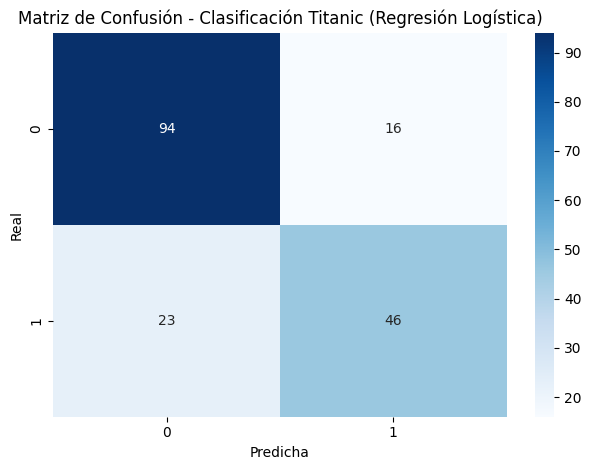

In [17]:
# Genera la matriz de confusión a partir de las etiquetas reales (y_test) y las predichas por el modelo (y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Crea una nueva figura para el gráfico
plt.figure()

# Dibuja la matriz de confusión como un mapa de calor
# - annot=True: muestra los valores numéricos en cada celda
# - cmap='Blues': usa una paleta de colores azules
# - fmt='d': muestra los números como enteros
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Establece el título del gráfico
plt.title('Matriz de Confusión - Clasificación Titanic (Regresión Logística)')

# Etiqueta del eje X: valores predichos por el modelo
plt.xlabel('Predicha')

# Etiqueta del eje Y: valores reales del conjunto de prueba
plt.ylabel('Real')

# Ajusta automáticamente el diseño para evitar solapamientos
plt.tight_layout()

# Muestra el gráfico en pantalla
plt.show()

### ¿Qué cambió en los números de verdaderos positivos y verdaderos negativos?
Los resultados empeoran a la hora de clasificar la no supervivencia, pero mejoran en la supervivencia.
* La clasificación de no supervivencia y que fuera así es de 94 (en random forest 104)
* Los falsos negativos ahora son 16 y en random forest 6.
* La clasificación de supervivencia correcta, ahora es 46, antes 37.
* Los falsos positivos ahora son 23, antes 32.

| Modelo | Muere pred correcta | Muere pred incorrecta | Vive pred correcta | Vive pred incorrecta | TOTAL |
|---------|----------|----------|------------|-------------|---------|
| Random Forest| 104 | 6 | 37 | 32 | 179 |
| Random Forest | 58% | 3% | 21% | 18% | 100% |
| Reg. logística| 94 | 16 | 46 | 23 | 179 |
| Reg. logística | 52% | 9% | 26% | 13% | 100% |

Random Forest ha clasificado incorrectamente un 21% de los 179 casos reservados para el test (20% de los 891 pasajeros).

Regresión Logística ha clasificado incorrectamente un 22% de los 179 casos reservados para el test (20% de los 891 pasajeros)

### Extraemos los coeficientes de las variables de un modelo de regresión logística y representamos su magnitud en un gráfico de barras.


In [18]:
# Extrae los coeficientes del modelo de regresión logística entrenado.
# Se accede al modelo entrenado para acceder a los coeficientes.
# Luego se selecciona el primer (y único) vector de coeficientes, ya que se asume un problema de clasificación binaria.
coefficients = model.coef_[0]

# Nombres de las características
feature_names = X_train_encoded.columns


### Representamos la magnitud de los coeficientes de las variables en un gráfico de barras

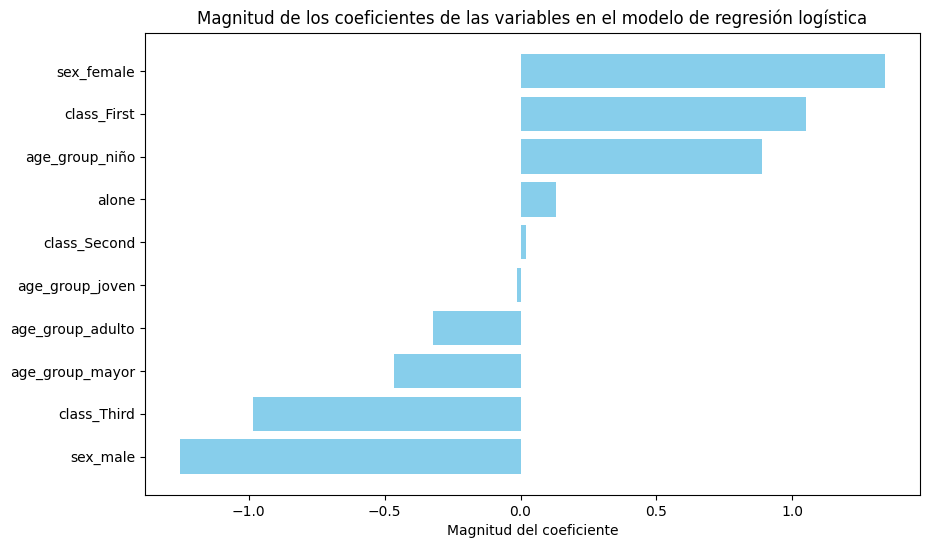


Precisión en el conjunto de prueba: 78.21%


In [19]:
# Crear un DataFrame con los coeficientes de las variables
importance_df = pd.DataFrame({
    'Feature': feature_names,       # Lista de nombres de las variables (feature_names)
    'Coefficient': coefficients    # Lista de coeficientes del modelo (coefficients)
}).sort_values(by='Coefficient', ascending=False)  # Ordena las filas por la magnitud del coeficiente

# Crear el gráfico de barras horizontales
# Este gráfico muestra la dirección del efecto de cada variable:
# - Coeficientes positivos indican que aumentan la probabilidad de supervivencia.
# - Coeficientes negativos indican que disminuyen la probabilidad de supervivencia.

plt.figure(figsize=(10, 6))  # Define el tamaño del gráfico
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='skyblue')  # Dibuja las barras horizontales con la magnitud absoluta de los coeficientes
plt.gca().invert_yaxis()  # Invierte el eje Y para que las variables más importantes aparezcan arriba
plt.title('Magnitud de los coeficientes de las variables en el modelo de regresión logística')  # Título del gráfico
plt.xlabel('Magnitud del coeficiente')  # Etiqueta del eje X
plt.show()  # Muestra el gráfico

# Calcular y mostrar la precisión del modelo en el conjunto de prueba
test_score = model.score(X_test_encoded, y_test)  # Evaluar el modelo en los datos de prueba
print(f"\nPrecisión en el conjunto de prueba: {test_score:.2%}")  # Imprime la precisión como porcentaje con dos decimales


Las variables con coeficientes negativos como sex_male y class_Third están asociadas a menor probabilidad de supervivencia. Esto indica que el modelo está aprendiendo correctamente los patrones históricos del desastre.

Los coeficientes positivos indican que al aumentar esa variable, aumenta la probabilidad de supervivencia. Los negativos indican lo contrario. Por ejemplo, ser hombre (sex_male) o viajar en tercera clase (class_Third) reduce la probabilidad de sobrevivir. Sin embargo, ser mujer (sex_female), viajar en primera clase (class_First) y ser niño (age_group_niño) fueron clave para sobrevivir.

Random Forest no tenía coeficientes como la regresión logística. En su lugar, habíamos calculado la importancia de cada variable según cuánto mejora la calidad de las divisiones en los árboles. Por eso, no se puede saber si una variable aumenta o disminuye la probabilidad de supervivencia, solo cuánto influye en la decisión.

## Paso 6: Interpretación de resultados para regresión logística
Analizamos los coeficientes del modelo de regresión logística para entender qué variables tienen mayor influencia en la predicción. A diferencia de Random Forest, donde se mide la importancia relativa, aquí los coeficientes indican la dirección y magnitud del efecto de cada variable sobre la probabilidad de supervivencia.

Por ejemplo, un coeficiente positivo indica que al aumentar esa variable, aumenta la probabilidad de que el pasajero sobreviva. Un coeficiente negativo indica que al aumentar esa variable, disminuye la probabilidad de supervivencia.

| Métrica | Random Forest | Regresión logística |
| ------- | ------------- | ------------------- |
| Precisión | 78.77% | 78.21% |
| Interpretabilidad | Baja | Alta |
| Tiempo de entrenamiento | Medio | Bajo |
| Capacidad de generalización | Alta (con suficientes datos) | Media (puede sobreajustar si hay multicolinealidad) |

Multicolinealidad es que varias variables predictoras están muy relacionadas entre sí, lo que dificulta saber qué está produciendo el efecto en la variable independiente.

### Conclusión:
Hemos entrenado dos modelos y comparado su rendimiento. Ambos ofrecen resultados similares, pero la regresión logística es más interpretable.

## Paso 7: Aplicación del modelo a nuevos datos
Creamos un conjunto ficticio de 10 pasajeros, aplicamos el mismo preprocesamiento y usamos el modelo de regresión logíatica (el último entrenado) para predecir si habrían sobrevivido.

### Creamos un dataframe ficticio

In [20]:
# Crear un DataFrame con 15 pasajeros ficticios
nuevos_pasajeros = pd.DataFrame({
    'sex': ['male', 'female', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'male', 'female', 'male', 'female', 'male'],
    'age': [25, 30, 22, 45, 18, 35, 28, 50, 40, 16, 24, 62, 7, 3, 38],
    'class': ['Third', 'Third', 'Second', 'First', 'Third', 'Second', 'First', 'First', 'Second', 'Third', 'First', 'Third', 'First', 'Third', 'Second'],
    'alone': [True, False, False, True, False, False, False, True, False, False, True, True, False, False, True]
})


### Imputación, codificación y escalado
Aplicar el mismo preprocesamiento que al conjunto de entrenamiento

In [21]:
# Convertimos la edad numérica en categorías para facilitar la interpretación
nuevos_pasajeros['age_group'] = nuevos_pasajeros['age'].apply(categorizar_edad)

# Eliminamos la columna original de edad porque ya tenemos la versión categórica
nuevos_pasajeros = nuevos_pasajeros.drop(columns='age')

# Imputamos valores faltantes usando la moda para variables categóricas
nuevos_pasajeros = nuevos_pasajeros.fillna(X_train.mode().iloc[0])

# Codificamos las variables categóricas en formato binario (One-Hot Encoding)
nuevos_encoded = pd.get_dummies(nuevos_pasajeros, drop_first=False)

# Alineamos las columnas con el conjunto de entrenamiento para evitar errores de predicción
nuevos_encoded = nuevos_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


### Predicción
Usamos el modelo de regresión logística entrenado previamente para predecir la supervivencia de los nuevos pasajeros.

In [22]:
# Predicción. La agregamos al DataFrame de nuevos_pasajeros
# Usamos el modelo entrenado para predecir si cada pasajero ficticio habría sobrevivido
nuevos_pasajeros['Resultado'] = model.predict(nuevos_encoded)
nuevos_pasajeros['Resultado'] = nuevos_pasajeros['Resultado'].map({0: 'No sobrevivió', 1: 'Sobrevivió'})


In [23]:

# Creamos etiquetas personalizadas para mostrar el resultado y características clave
etiquetas = [
    f"{i+1}: {res}\n{sexo}, {edad}, {clase}"
    for i, (res, sexo, edad, clase) in enumerate(zip(
        nuevos_pasajeros['Resultado'],
        nuevos_pasajeros['sex'],
        nuevos_pasajeros['age_group'],
        nuevos_pasajeros['class']
    ))
]


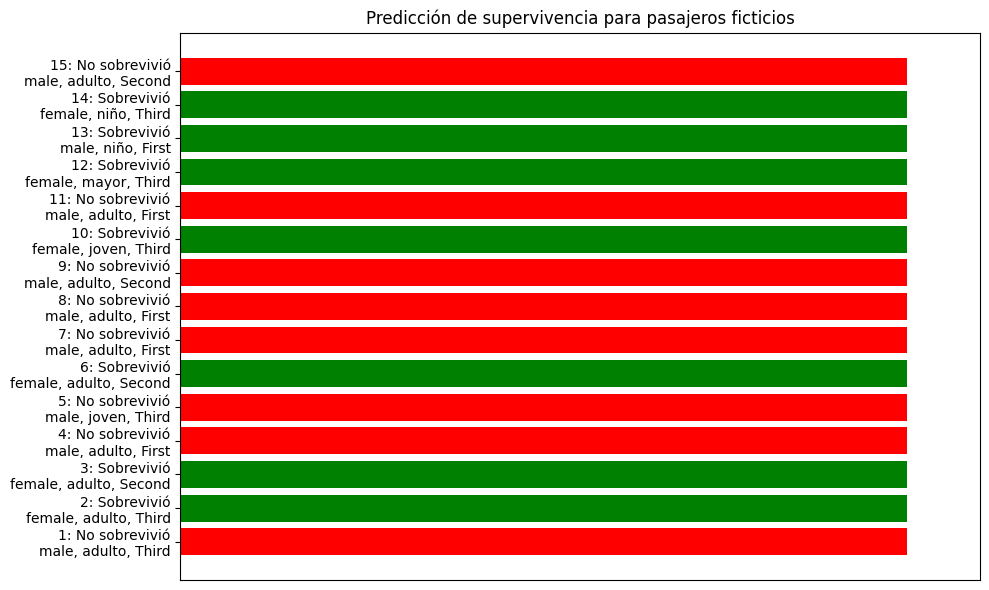

In [24]:
# Visualización

# Visualizamos cada pasajero con su resultado y características clave (sexo, edad, clase)
colores = ['green' if r == 'Sobrevivió' else 'red' for r in nuevos_pasajeros['Resultado']]
plt.figure(figsize=(10, 6))
plt.barh(etiquetas, [1]*len(etiquetas), color=colores)

plt.xlim(0, 1.1)
plt.title('Predicción de supervivencia para pasajeros ficticios')
plt.xticks([])  # Oculta los valores del eje X (no aporta ninguna información)
plt.xlabel('')  # Elimina la etiqueta del eje X
plt.tight_layout()
plt.show()

Podemos observar que el modelo predice mayor supervivencia en mujeres, niños y pasajeros de primera clase, lo cual coincide con los patrones históricos del desastre.